The Monte-Carlo data format looks a bit different. Partly because we're simulating version 3 of the HGCROC, and because makeAnalysisFiles.py does a little less pre-processing of the data before saving it to the .csv  

In the MC data, there are now eight TOT values, one for each sample. There are also 8 flags, "TOT complete", and 8 flags "TOT progress"

If TOT complete (Tc) or TOT progress (Tp) are set to true in any of the eight samples, you should probably discard the ADC information in any sample (but especially in the samples with Tc or Tp set to true)

If Tc is set to false, the TOT value in that sample does not say anything useful (in fact, it probably just mirrors the ADC value).

If Tc is set to true, then that sample stores the TOT value. 

Samples with Tp set to true don't hold any useful information at all.

To make it easy for us, I've made a helper class that:
    - Checks whether a pulse is in ADC or TOT mode
    - Extracts the raw TOT value
    - Converts the raw TOT value to sum-of-ADC, based on some calibration.

Here's an example:

In [1]:
!pip install -r ../requirements.txt

import sys
sys.path.append('../src')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import math

import pandas as pd
import numpy as np


In [19]:
from mcTOTHelper import MCTOTHelper

#Get an instance of the helper class, using this particular calibration file
#TOThelper = MCTOTHelper("../calibrations/mc_v6_tot_calibration.csv")
TOThelper = MCTOTHelper("mc_v6_tot_calibration.csv")

In [32]:
mcdata = pd.read_csv('../analysis_files/muon_4GeV_MC_v6.csv')

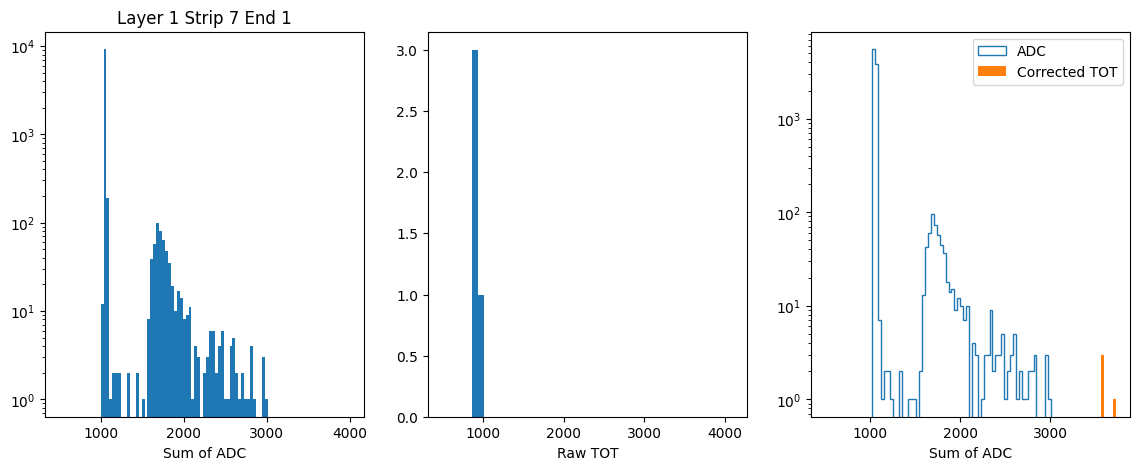

In [33]:
layer = 1
strip = 7
end = 1

events = mcdata.loc[mcdata['layer'] == layer].loc[mcdata['strip'] == strip]

sum_adc = []
tot = []
tot_corrected = []

#Go through each pulse
for index, row in events.iterrows():
    #Check if this pulse is in TOT mode (returns -1 otherwise)
    if TOThelper.get_Tc_index(row,end) != -1:
        #If so, get the TOT value out of the pulse
        rawtot = TOThelper.get_TOT(row,end)
        tot.append(rawtot)
        #And correct it to sum of ADC
        tot_corrected.append(TOThelper.correct_TOT(layer,strip,end,rawtot))
    else:
        sum_adc.append(row["adc_sum_end"+str(end)])

fig, axs = plt.subplots(1,3, figsize=(14,5))
adcbins = np.linspace(500,4000,100)

#sum_adc = [x for x in sum_adc if x > 1200 and x < 2000]

axs[0].hist(sum_adc, bins=adcbins)
axs[0].set_yscale("log")
axs[0].set_xlabel("Sum of ADC")
totbins = np.linspace(500,4096, 50)
axs[1].hist(tot, bins=totbins)
axs[1].set_xlabel("Raw TOT")

combinedhistbins = np.linspace(500,max(tot_corrected),100)
axs[2].hist(sum_adc, bins=combinedhistbins, histtype="step", label="ADC")
axs[2].hist(tot_corrected,bins=combinedhistbins, label="Corrected TOT")
axs[2].set_yscale("log")
axs[2].set_xlabel("Sum of ADC")
axs[2].legend()

axs[0].set_title("Layer " + str(layer) + " Strip " + str(strip) + " End " + str(end))
plt.show()